# Human Activity Recognition Using CSI and Deep Learning

### 📝 Project Overview

In this project, we build a deep learning model to recognize human activities based on Wi-Fi Channel State Information (CSI) data. CSI provides fine-grained information about the wireless signal environment, and has promising applications in human sensing without requiring wearable devices.

This notebook walks through a full machine learning pipeline, including:

- **Loading and visualizing CSI data** to better understand the underlying patterns
- **Preprocessing** and **structuring** the data for deep learning models
- **Building a CNN-LSTM architecture** to capture both spatial and temporal features
- **Training and validating** the model with a clear focus on performance tracking
- **Fine-tuning the model** to explore improvement strategies
- **Evaluating final results** with metrics like accuracy and confusion matrices

The primary goal is **educational**: showing how CSI data can be processed for classification tasks, how hybrid neural networks (CNN + LSTM) can be structured, and how training routines can be modularized for experimentation.

Even though fine-tuning resulted in a modest gain in accuracy, the project sets a solid foundation for further improvements, including hyperparameter search, alternative architectures, and more advanced evaluation techniques.

### 📂 Dataset Source

The dataset used is from [Figshare](https://figshare.com/articles/dataset/Dataset_for_Human_Activity_Recognition_using_Wi-Fi_Channel_State_Information_CSI_data/14386892) and contains Wi-Fi CSI data collected across multiple sessions and rooms.

License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)

### 🎯 Final Model Performance

- **Accuracy**: ~98% (the number might be slightly different in each run)
- **Observations**: Fine-tuning yielded only marginal improvements, indicating that the baseline CNN-LSTM architecture already captures much of the discriminative signal structure. Future work may involve experimenting with different architectures like Transformers or deeper CNN stacks.


## 0. Install and Import Essential Libraries

This section ensures that all necessary libraries are available and imports them for use. We rely on PyTorch for building and training our deep learning model, NumPy and Pandas for data handling, and Matplotlib/Seaborn for visualization.

Make sure to run this section before proceeding if you're in a fresh environment (e.g., Google Colab).

In [4]:
# Install PyTorch if not already available
!pip install torch

In [5]:
# Import standard libraries for data processing and machine learning
import pandas as pd
import numpy as np
import os
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Import torch libraries for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

## 1. Load The Dataset and Visualization

This section is dedicated to loading the CSI (Channel State Information) dataset and performing basic exploratory data analysis. We define utility functions to visualize CSI samples in the form of heatmaps, which are essential for understanding the raw signal structure. The dataset contains CSI amplitude values collected from different human activity sessions, and each sample is associated with a specific activity label.

To better understand the characteristics of the CSI signals, we visualize:

- Heatmaps of CSI signals over time and subcarriers
- Subcarrier signal evolution across time
- Distribution of raw and processed CSI values

This step provides intuition about how the activities differ in wireless signal space.

In [7]:
# Loads raw CSI data and corresponding labels from preprocessed CSV files.
# Drop the last sample to fix known bug in dataset
def load_raw_csi_data(data_path="data/data.csv", label_path="data/label.csv"):
    df_data = pd.read_csv(data_path, header=None)
    df_label = pd.read_csv(label_path, header=None)
    
    X_raw = df_data.values[:-1] # the last data point was reported to be a bug
    y_raw = df_label.values[:, 1]
    
    return X_raw, y_raw

In [8]:
X, y = load_raw_csi_data()
print(X.shape, y.shape)

(5229, 1026) (5229,)


In [9]:
# Plots CSI signal data as heatmaps to visually inspect signal patterns.
# Each subplot corresponds to one example per activity class.
def plot_csi_heatmap_grid(X_raw, y_raw, num_subcarriers=114):
    # extract the classes
    classes = np.unique(y_raw)
    n_classes = len(classes)

    # configure the grid
    n_cols = 3
    n_rows = math.ceil(n_classes / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.flatten()

    for i, cls in enumerate(classes):
        idx = np.where(y_raw == cls)[0][0]
        raw_vector = X_raw[idx].astype(float)
        time_steps = raw_vector.shape[0] // num_subcarriers
        sample = raw_vector.reshape(num_subcarriers, time_steps).T  # (T, F)

        sns.heatmap(sample, cmap='viridis', ax=axes[i], cbar=False)
        title = f"Action: {cls}"
        axes[i].set_title(title)
        axes[i].set_xlabel("Subcarriers")
        axes[i].set_ylabel("Time")

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("CSI Heatmap per Class", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

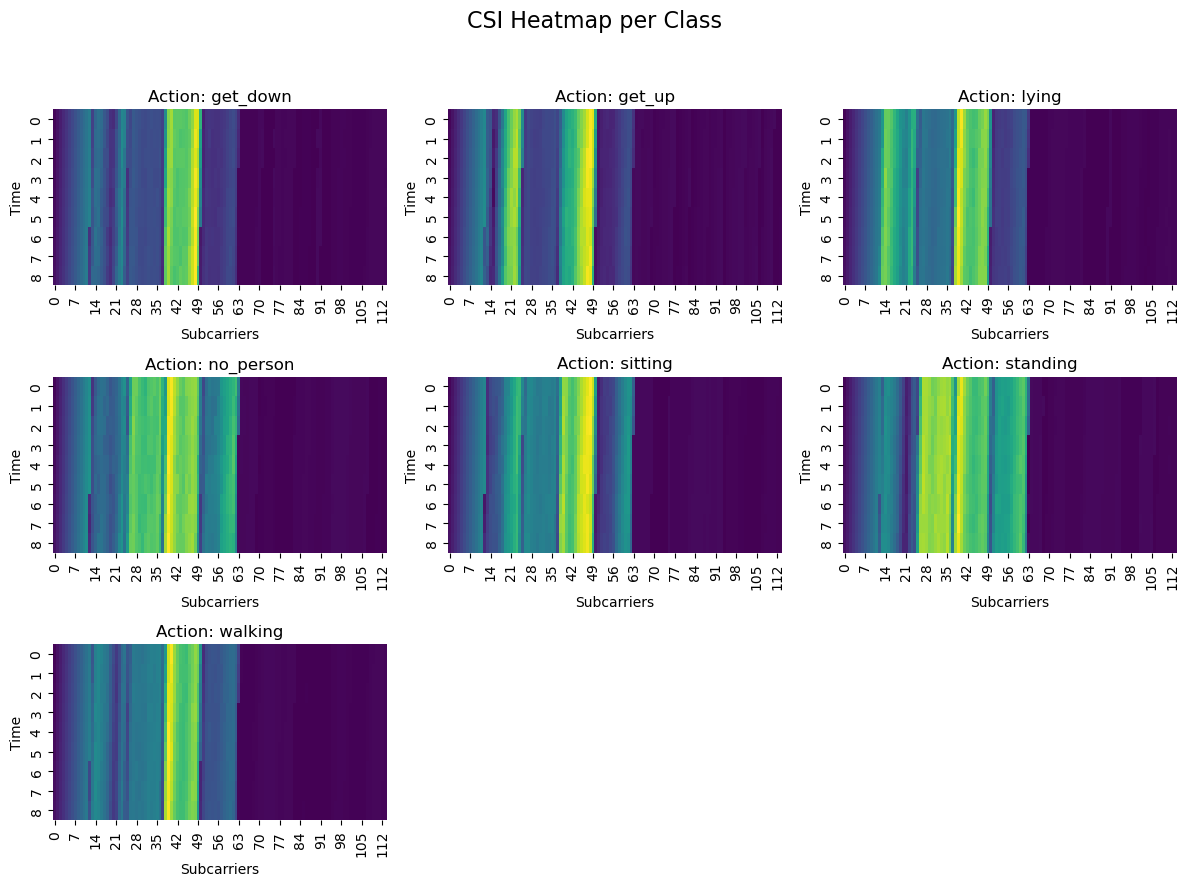

In [10]:
plot_csi_heatmap_grid(X, y, num_subcarriers=114)

These heatmaps visualize the raw CSI signal patterns over time for different activity classes. Each row represents a time step, and each column corresponds to a subcarrier.

✅ Insights:
- Some activities (e.g., standing still) show very little temporal variation.
- Others (e.g., walking or turning) exhibit more dynamic changes in amplitude over time.
- CSI values in the raw form can be noisy or inconsistent, motivating the need for preprocessing.

In [12]:
def plot_subcarriers_over_time(X_raw, y_raw, subcarriers=[0, 20, 40, 60], num_subcarriers=114):
    classes = np.unique(y_raw)
    n_classes = len(classes)
    n_cols = 3
    n_rows = math.ceil(n_classes / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))
    axes = axes.flatten()

    for i, cls in enumerate(classes):
        idx = np.where(y_raw == cls)[0][0]
        raw_vector = X_raw[idx].astype(float)
        time_steps = raw_vector.shape[0] // num_subcarriers
        sample = raw_vector.reshape(num_subcarriers, time_steps)  # (F, T)

        for sc in subcarriers:
            axes[i].plot(sample[sc], label=f'SC {sc}')
        title = f"Action: {cls}"
        axes[i].set_title(title)
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("Amplitude")
        axes[i].legend()

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Subcarrier Signals Over Time (One Sample per Class)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

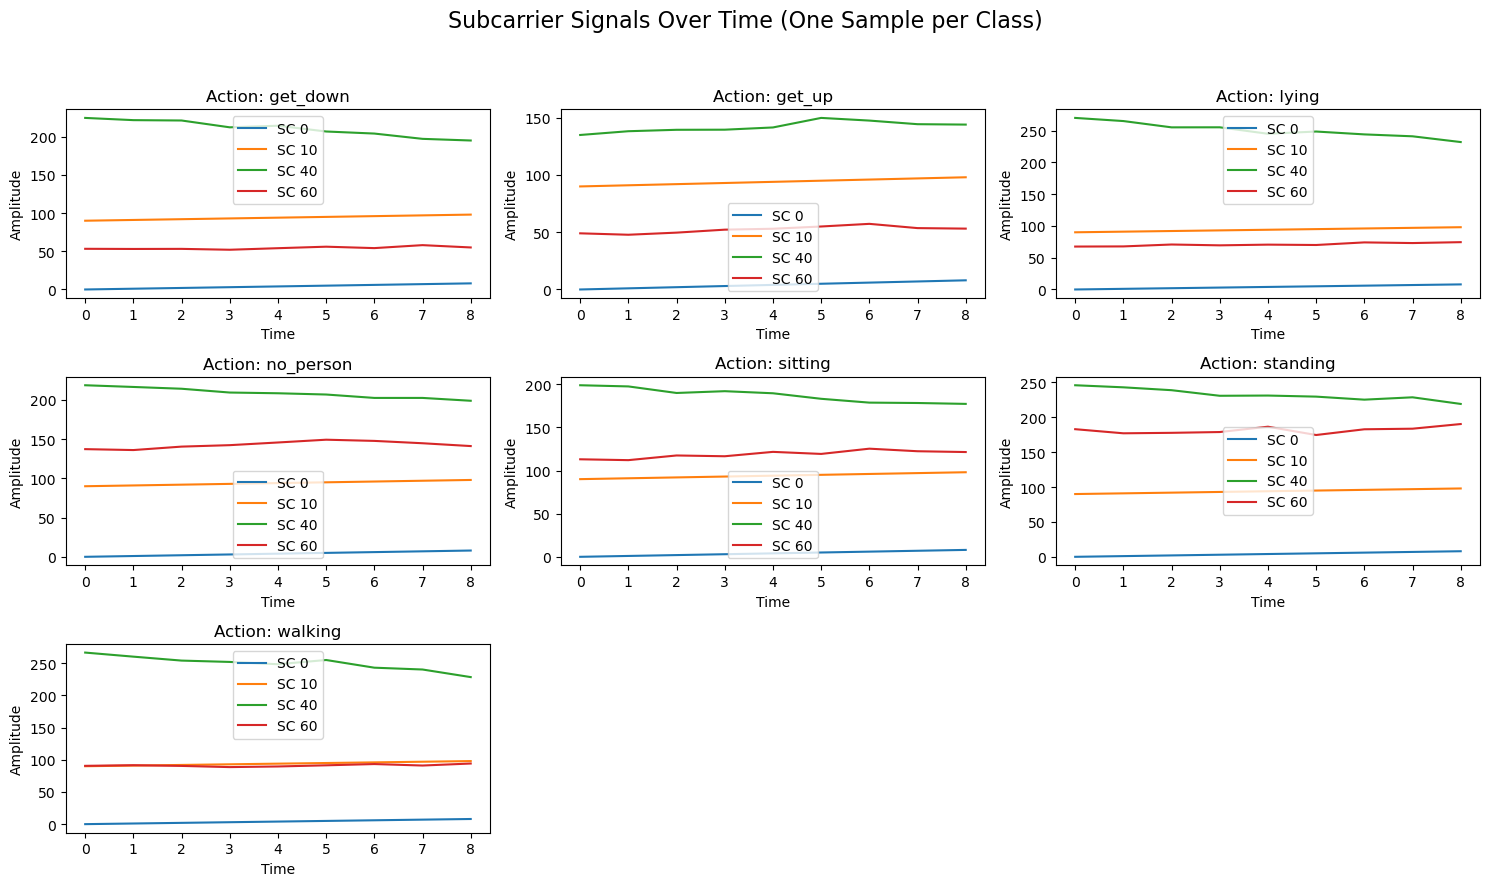

In [13]:
plot_subcarriers_over_time(X, y, subcarriers=[0, 10, 40, 60])

In this plot, we observe the amplitude of selected subcarriers over time for one representative sample per activity class. Each subplot corresponds to a different class, and each line represents a specific subcarrier.

✅ Insights:
- The raw CSI signals exhibit varying levels of fluctuation depending on the activity.
- Activities involving motion (e.g., walking, turning) show more dynamic and irregular subcarrier fluctuations across time.
- In contrast, static activities (e.g., sitting, standing) often show flatter and more stable traces.
- Some subcarriers are particularly noisy or jumpy, suggesting the presence of environmental noise or sensitivity to interference.
- These patterns are valuable but hard to learn from in raw form due to inconsistency in scale and smoothness across samples.

In [15]:
def plot_signal_distribution(X_raw, y_raw):
    classes = np.unique(y_raw)
    n_classes = len(classes)
    n_cols = 3
    n_rows = math.ceil(n_classes / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))
    axes = axes.flatten()

    for i, cls in enumerate(classes):
        idx = np.where(y_raw == cls)[0][0]
        raw_vector = X_raw[idx].astype(float)  # (F*T,)

        sns.histplot(raw_vector, bins=50, kde=True, ax=axes[i])
        title = f"Action: {cls}"
        axes[i].set_title(title)
        axes[i].set_xlabel("CSI Amplitude")
        axes[i].set_ylabel("Frequency")

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Distribution of CSI Values (One Sample per Class)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

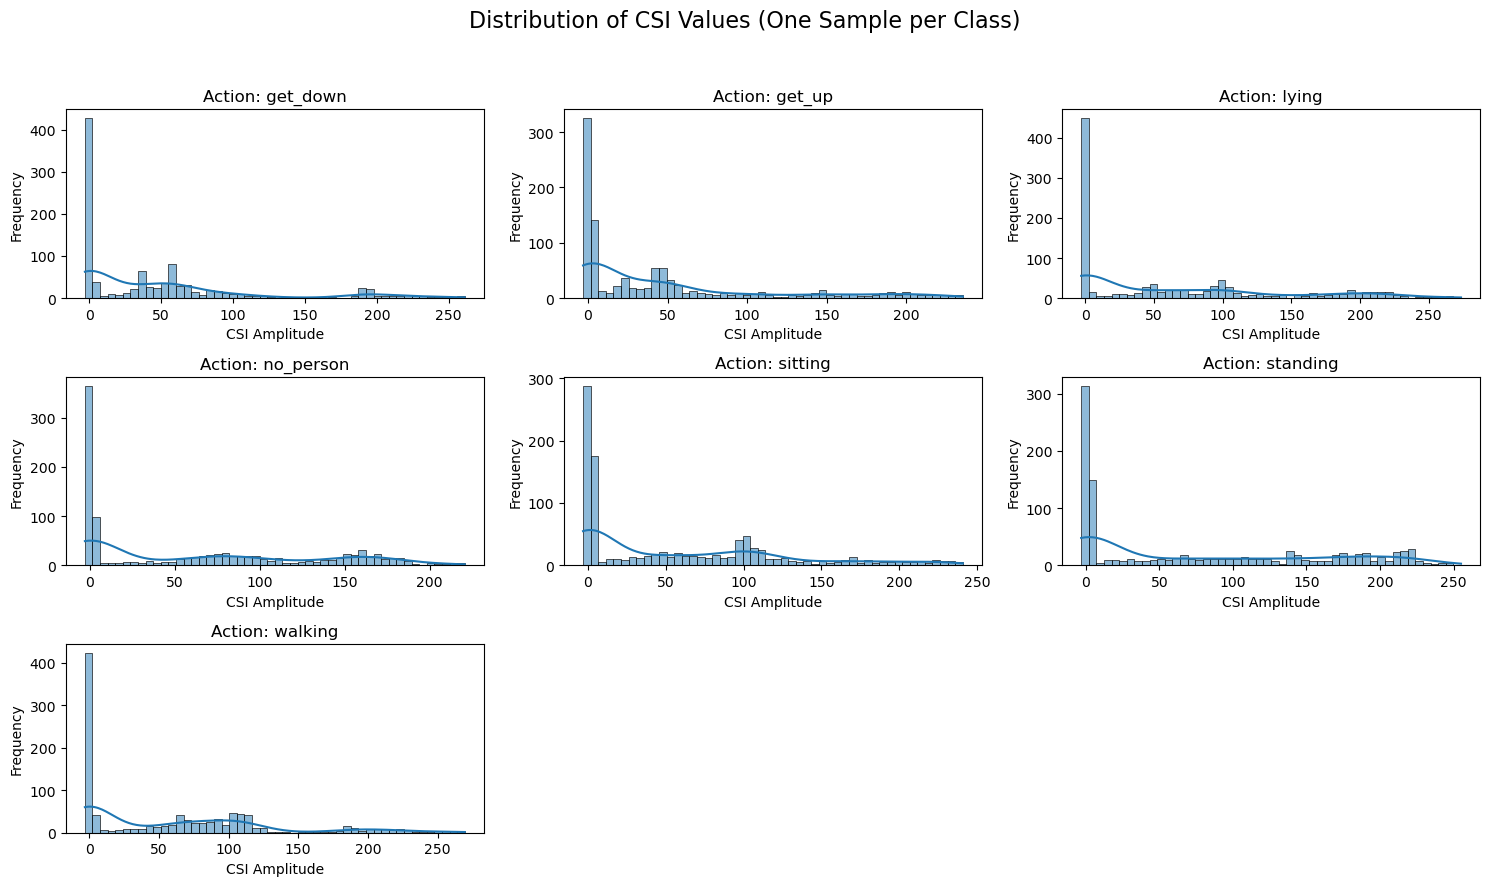

In [16]:
plot_signal_distribution(X, y)

This histogram shows the distribution of raw CSI values for different classes.

✅ Insights:
- The raw values follow a broad distribution with varying spread depending on the activity.
- Some classes have long-tailed distributions, indicating the presence of outliers or more motion.
- Highlights the need for normalization to bring features onto the same scale.

## 2. Preprocess The Data

The raw CSI data is reshaped into (T, F) matrices, where T is the number of time steps and F is the number of subcarriers. We apply normalization (zero mean, unit variance) across each sample and optionally smooth the signals across time. Additionally, we extract simple statistical features (mean, std, min, max, energy) to augment the input features, making the model more robust.

In [19]:
# Reshape each sample into (subcarriers, time_steps) and normalize
# Add simple statistical features (mean, std, min, max, energy) for augmentation
def preprocess_csi_data(X_raw, y_raw, num_subcarriers=114, smoothing_window=3, augment=False):
    num_samples, num_features = X_raw.shape
    if num_features % num_subcarriers != 0:
        raise ValueError(f"Feature count {num_features} is not divisible by {num_subcarriers}.")

    time_steps = num_features // num_subcarriers
    
    # reshaping to (N, F, T) where N = no. of samples, T = n
    X = X_raw.reshape((num_samples, num_subcarriers, time_steps))

    # transpose to (N, T, F)
    X = np.transpose(X, (0, 2, 1))

    # Normalize each sample across subcarriers and time
    mean = np.mean(X, axis=(1, 2), keepdims=True)
    std = np.std(X, axis=(1, 2), keepdims=True)
    X = (X - mean) / (std + 1e-6)

    # Smoothing
    padded = np.pad(X, ((0, 0), (smoothing_window//2, smoothing_window//2), (0, 0)), mode='reflect')
    X = np.stack([np.mean(padded[:, i:i + smoothing_window, :], axis=1)
                  for i in range(X.shape[1])], axis=1)

    # Statistical features
    def extract_stats(x):
        mean = np.mean(x, axis=1)
        std = np.std(x, axis=1)
        min_ = np.min(x, axis=1)
        max_ = np.max(x, axis=1)
        energy = np.sum(np.square(x), axis=1)
        return np.stack([mean, std, min_, max_, energy], axis=1)

    # concatenate statistics along the time axis
    X_stats = extract_stats(X)
    print(f"Reshaping to (samples={num_samples}, time_steps and stats={time_steps + 5}, subcarriers={num_subcarriers})")
    X_aug = np.concatenate([X, X_stats], axis=1)  # shape: (N, T+5, F)

    # label encoding
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_raw)

    return X_aug, y_encoded, label_encoder

In [20]:
X_processed, y_processed, label_encoder = preprocess_csi_data(X, y)
print(X_processed.shape, y_processed.shape)

Reshaping to (samples=5229, time_steps and stats=14, subcarriers=114)
(5229, 14, 114) (5229,)


In [21]:
# Print the label index-to-activity mapping
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

0: get_down
1: get_up
2: lying
3: no_person
4: sitting
5: standing
6: walking


In [22]:
# Print the class distribution
labels = y_processed
label_names = label_encoder.classes_

unique, counts = np.unique(labels, return_counts=True)

print("Class Distribution:")
for label, count in zip(unique, counts):
    print(f"{label}: {label_names[label]} → {count} samples")

Class Distribution:
0: get_down → 275 samples
1: get_up → 265 samples
2: lying → 625 samples
3: no_person → 600 samples
4: sitting → 460 samples
5: standing → 524 samples
6: walking → 2480 samples


In [23]:
def plot_processed_csi_grid(X_processed, y_processed, class_names=None):
    """
    Plot a grid of one preprocessed CSI heatmap per class.
    Assumes X_processed has shape (N, T+5, F) and y_processed has shape (N,)
    """
    classes = np.unique(y_processed)
    n_classes = len(classes)
    n_cols = 3
    n_rows = math.ceil(n_classes / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.flatten()

    for i, cls in enumerate(classes):
        idx = np.where(y_processed == cls)[0][0]
        sample = X_processed[idx]  # shape: (T+5, F)

        sns.heatmap(sample, cmap='YlOrBr', ax=axes[i], cbar=False)
        title = f"Action: {class_names[cls]}"
        axes[i].set_title(title)
        axes[i].set_xlabel("Subcarriers")
        axes[i].set_ylabel("Time + Stats")

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("One Preprocessed CSI Heatmap per Class", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

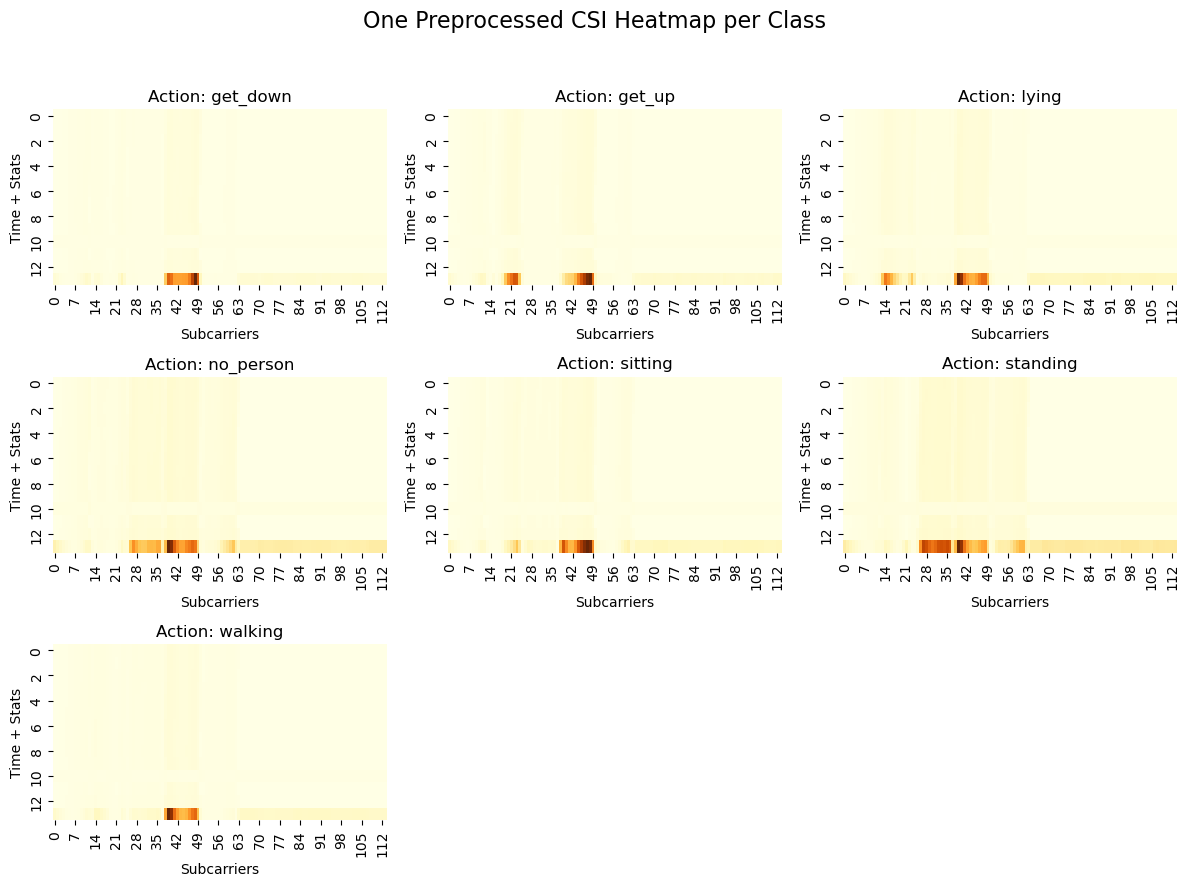

In [24]:
plot_processed_csi_grid(X_processed, y_processed, class_names=label_encoder.classes_)

Here we plot the same classes as above, but after preprocessing (normalization, smoothing, and statistical feature augmentation).

✅ Insights:
- The processed signals are more consistent and distinguishable across time steps.
- Statistical rows (added below the original time-series) help enhance the feature space, showing a clear contrast between different activity classes.
- The structure is now cleaner and easier for models to interpret.

In [26]:
# Plot selected subcarriers over time for one preprocessed sample per class.
def plot_processed_subcarriers(X_processed, y_processed, subcarriers=[0, 20, 40, 60], class_names=None):
    classes = np.unique(y_processed)
    n_classes = len(classes)
    n_cols = 3
    n_rows = math.ceil(n_classes / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))
    axes = axes.flatten()

    for i, cls in enumerate(classes):
        idx = np.where(y_processed == cls)[0][0]
        sample = X_processed[idx]  # (T+5, F)

        for sc in subcarriers:
            axes[i].plot(sample[:, sc], label=f'SC {sc}')
        title = f"Action: {class_names[cls]}"
        axes[i].set_title(title)
        axes[i].set_xlabel("Time + Stats")
        axes[i].set_ylabel("Amplitude")
        axes[i].legend()

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Processed CSI: Subcarriers Over Time (One Sample per Class)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

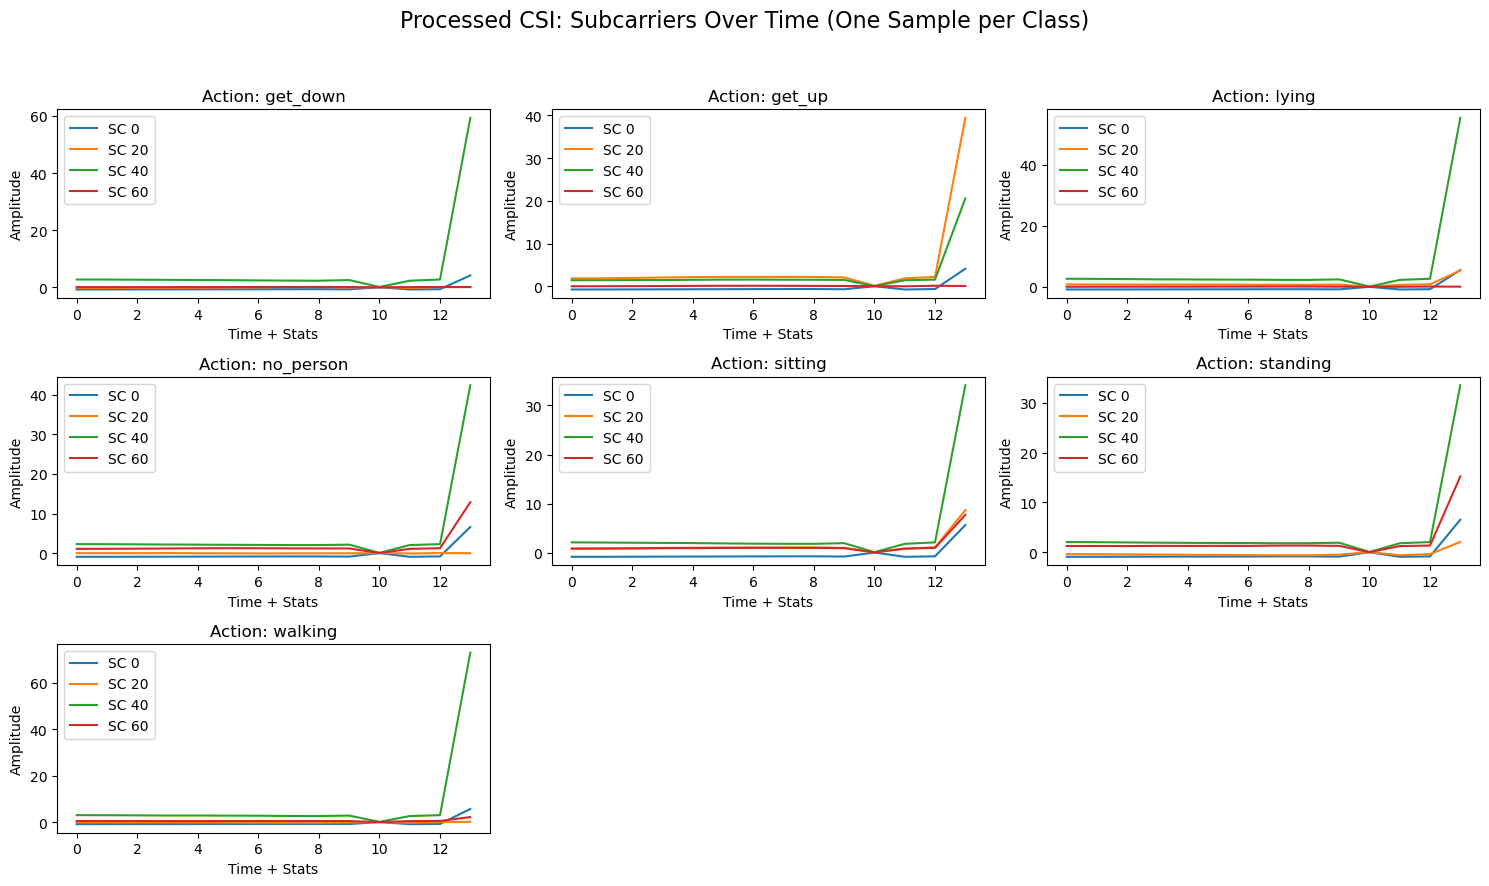

In [27]:
plot_processed_subcarriers(X_processed, y_processed, subcarriers=[0, 20, 40, 60], class_names=label_encoder.classes_)

This figure shows the same subcarriers plotted across time after applying normalization, smoothing, and statistical augmentation.

✅ Insights:
- Signal fluctuations are smoother, with less abrupt noise or jitter.
- The baseline of each subcarrier is now consistent across samples, thanks to per-sample normalization.
- Discriminative patterns are retained — dynamic classes still show larger changes over time — but in a more stable and learnable format.
- The smoothing step appears to reduce overfitting by dampening signal spikes that may not generalize well.
- The enhanced consistency across samples and classes allows the CNN-LSTM model to focus more on meaningful temporal patterns rather than raw scale.

In [29]:
# Plot histogram (with KDE) of processed CSI values for one sample per class.
def plot_processed_signal_distribution(X_processed, y_processed, class_names=None):
    classes = np.unique(y_processed)
    n_classes = len(classes)
    n_cols = 3
    n_rows = math.ceil(n_classes / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))
    axes = axes.flatten()

    for i, cls in enumerate(classes):
        idx = np.where(y_processed == cls)[0][0]
        sample = X_processed[idx]  # shape: (T+5, F)
        values = sample.flatten()

        sns.histplot(values, bins=50, kde=True, ax=axes[i])
        title = f"Action: {class_names[cls]}"
        axes[i].set_title(title)
        axes[i].set_xlabel("Normalized Amplitude")
        axes[i].set_ylabel("Frequency")

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Distribution of Processed CSI Values (One Sample per Class)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

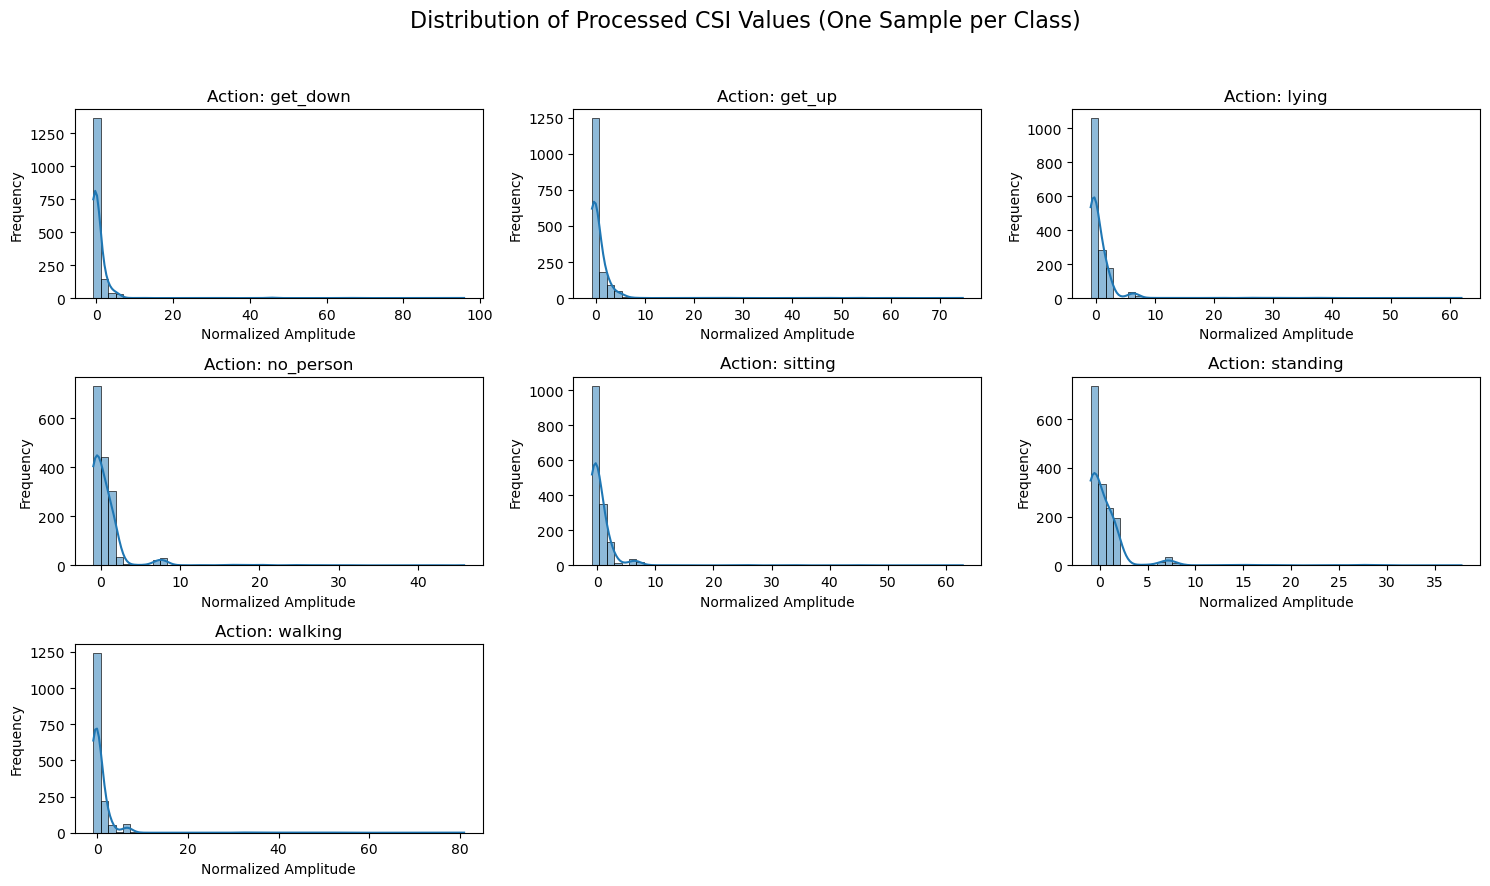

In [30]:
plot_processed_signal_distribution(X_processed, y_processed, class_names=label_encoder.classes_)

These histograms show the distribution of CSI values after preprocessing.

✅ Insights:
- Post-normalization, the values are centered around 0 with tighter spread.
- All classes now follow a similar shape which makes training more stable.
- Confirms that the preprocessing pipeline successfully standardizes the data.

In [32]:
# split the data to train, val, and test set
def train_test_val_split(X, y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    
    assert len(X_train) == len(y_train)
    assert len(X_val) == len(y_val)
    assert len(X_test) == len(y_test)
    print("Train / Val / Test data sizes:", len(X_train), len(X_val), len(X_test))
    print("Train / Val / Test label sizes:", len(y_train), len(y_val), len(y_test))
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [33]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X_processed, y_processed)

Train / Val / Test data sizes: 3660 784 785
Train / Val / Test label sizes: 3660 784 785


In [34]:
# Print the class distribution in the train set
labels = y_train
label_names = label_encoder.classes_

unique, counts = np.unique(labels, return_counts=True)

print("Train Class Distribution:")
for label, count in zip(unique, counts):
    print(f"{label}: {label_names[label]} → {count} samples")

Train Class Distribution:
0: get_down → 192 samples
1: get_up → 186 samples
2: lying → 437 samples
3: no_person → 420 samples
4: sitting → 322 samples
5: standing → 367 samples
6: walking → 1736 samples


In [35]:
# Print the class distribution in the val set
labels = y_val
label_names = label_encoder.classes_

unique, counts = np.unique(labels, return_counts=True)

print("Val Class Distribution:")
for label, count in zip(unique, counts):
    print(f"{label}: {label_names[label]} → {count} samples")

Val Class Distribution:
0: get_down → 41 samples
1: get_up → 40 samples
2: lying → 94 samples
3: no_person → 90 samples
4: sitting → 69 samples
5: standing → 78 samples
6: walking → 372 samples


In [36]:
# Print the class distribution in the test set
labels = y_test
label_names = label_encoder.classes_

unique, counts = np.unique(labels, return_counts=True)

print("Test Class Distribution:")
for label, count in zip(unique, counts):
    print(f"{label}: {label_names[label]} → {count} samples")

Test Class Distribution:
0: get_down → 42 samples
1: get_up → 39 samples
2: lying → 94 samples
3: no_person → 90 samples
4: sitting → 69 samples
5: standing → 79 samples
6: walking → 372 samples


## 3. Build CNN-LSTM Model

We define a hybrid deep learning architecture combining CNNs (to extract local spatial features from subcarriers) and LSTMs (to model temporal dependencies across time steps). This combination is particularly effective for time-series classification tasks like human activity recognition from CSI data. In particular,

- CNN layers extract local temporal patterns from CSI subcarrier sequences.
- A Bidirectional LSTM captures longer-range dependencies over time.
- A fully connected layer outputs the final class predictions.

The model is trained end-to-end using a smoothed cross-entropy loss function.

In [38]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y), f"Mismatch between number of samples {len(X)} and labels {len(y)}"
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CNNLSTM, self).__init__()
        # CNN extracts local time-frequency features from CSI data
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 128, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Conv1d(128, 256, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3)
        )
        # BiLSTM captures sequence dependencies forward and backward
        self.lstm = nn.LSTM(
            input_size=256, 
            hidden_size=hidden_size, 
            batch_first=True,
            bidirectional=True
        )
        # Final FC layer maps hidden features to activity classes
        self.fc = nn.Linear(hidden_size * 2, num_classes) # double the hidden size since we set bidirectional to True

    def forward(self, x):
        x = x.permute(0, 2, 1)         # (B, F, T)
        x = self.cnn(x)                # (B, 256, T)
        x = x.permute(0, 2, 1)         # (B, T, 256)
        _, (h_n, _) = self.lstm(x)     # h_n: (4, B, H)
        h_cat = torch.cat((h_n[-2], h_n[-1]), dim=1) # last forward & backward
        return self.fc(h_cat) # (B, C)

In [39]:
input_size = X_processed.shape[2] # no. of subcarries = 114
hidden_size = 128 # hyper-parameter
num_classes = len(label_encoder.classes_)

# define the initial model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_lstm_model = CNNLSTM(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
cnn_lstm_model

CNNLSTM(
  (cnn): Sequential(
    (0): Conv1d(114, 128, kernel_size=(5,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
  )
  (lstm): LSTM(256, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)

## 4. Train and Evaluate The Initial Model

The model is trained using the Adam optimizer with a ReduceLROnPlateau scheduler to adaptively lower the learning rate. Early stopping based on validation accuracy prevents overfitting. Finally, we evaluate the model using classification metrics such as precision, recall, and F1-score across all activity classes.

In [41]:
def plot_confusion_matrix(y_true, y_pred, classes):
    c_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device, print_report=True, class_names=None):
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(y_batch.numpy())
    if print_report:
        print(classification_report(y_true, y_pred, target_names=class_names if class_names is not None else None))
        if class_names is not None:
            plot_confusion_matrix(y_true, y_pred, class_names)

    correct_preds = np.sum(np.array(y_pred) == np.array(y_true))
    return correct_preds / len(y_true)

In [42]:
def train_model(model, train_loader, val_loader, device, learning_rate, epochs, checkpoint_path='best_model.pt'):
   # Train model using Adam optimizer and smoothed cross-entropy loss
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Apply learning rate scheduling based on validation accuracy
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    
    model.to(device)

    best_val_acc = 0
    patience_counter = 0
    early_stopping_patience = 10 # can change if we use different numbers of epochs

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_acc = evaluate_model(model, val_loader, device, print_report=False)
        scheduler.step(val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        # Save best model checkpoint during training
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), checkpoint_path)
            patience_counter = 0
            print("Model checkpoint saved.")
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

In [43]:
batch_size = 64
train_loader = DataLoader(CSIDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(CSIDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(CSIDataset(X_test, y_test), batch_size=batch_size)

In [44]:
epochs = 50 # can change if we need to train longer
learning_rate = 1e-3
train_model(cnn_lstm_model, train_loader, val_loader, device, learning_rate, epochs)

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Loss: 55.5026, Val Accuracy: 0.6837
Model checkpoint saved.
Epoch 2/50 - Loss: 37.6641, Val Accuracy: 0.8227
Model checkpoint saved.
Epoch 3/50 - Loss: 31.6159, Val Accuracy: 0.8151
Epoch 4/50 - Loss: 27.7759, Val Accuracy: 0.7691
Epoch 5/50 - Loss: 24.6336, Val Accuracy: 0.7487
Epoch 6/50 - Loss: 24.5192, Val Accuracy: 0.8776
Model checkpoint saved.
Epoch 7/50 - Loss: 21.7934, Val Accuracy: 0.7168
Epoch 8/50 - Loss: 20.5400, Val Accuracy: 0.8469
Epoch 9/50 - Loss: 19.7965, Val Accuracy: 0.7997
Epoch 10/50 - Loss: 19.5895, Val Accuracy: 0.8878
Model checkpoint saved.
Epoch 11/50 - Loss: 18.0506, Val Accuracy: 0.8099
Epoch 12/50 - Loss: 15.8173, Val Accuracy: 0.9005
Model checkpoint saved.
Epoch 13/50 - Loss: 14.6374, Val Accuracy: 0.8036
Epoch 14/50 - Loss: 13.2933, Val Accuracy: 0.7360
Epoch 15/50 - Loss: 13.3918, Val Accuracy: 0.8546
Epoch 16/50 - Loss: 14.5822, Val Accuracy: 0.8929
Epoch 17/50 - Loss: 12.1573, Val Accuracy: 0.8916
Epoch 18/50 - Loss: 10.9096, Val Accura

              precision    recall  f1-score   support

    get_down       0.91      0.93      0.92        42
      get_up       0.95      0.92      0.94        39
       lying       0.99      0.99      0.99        94
   no_person       1.00      0.97      0.98        90
     sitting       0.97      1.00      0.99        69
    standing       0.97      0.96      0.97        79
     walking       0.99      0.99      0.99       372

    accuracy                           0.98       785
   macro avg       0.97      0.97      0.97       785
weighted avg       0.98      0.98      0.98       785



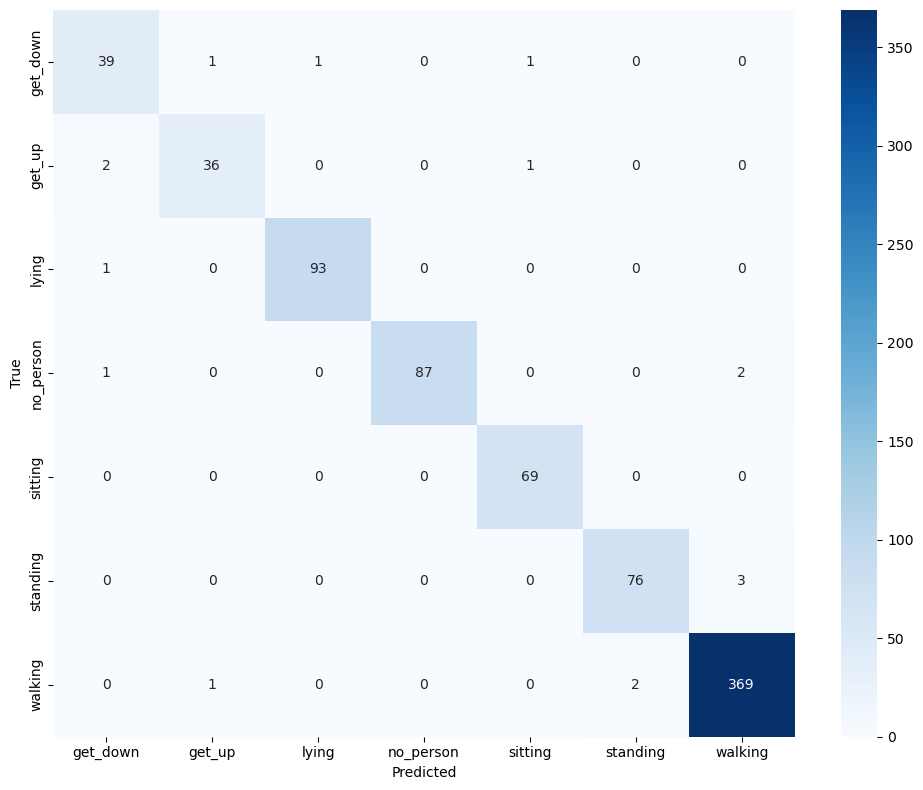

Accuracy: 0.9796178343949045


In [45]:
acc = evaluate_model(cnn_lstm_model, test_loader, device, True, label_encoder.classes_)
print(f"Accuracy: {acc}")

Recall the Activity Label Mapping based on the label.csv file and the distribution of the classes in the test set.

| Label Index | Activity Name | Sample Count |
|-------------|----------------|---------------|
| 0           | get_down       | 42            |
| 1           | get_up         | 39            |
| 2           | lying          | 94            |
| 3           | no_person      | 90            |
| 4           | sitting        | 69            |
| 5           | standing       | 79            |
| 6           | walking        | 372           |

✅ Insights:

- **Lying**, **No-Person**, and **Walking** are classified with high accuracy, showing strong diagonal dominance and minimal confusion.
- **Sitting** and **Standing** show mild confusion with each other, likely due to their similar static nature and subtle movement differences.
- The most significant confusion occurs in **Get-Down** and **Get-Up**. These are both short, transitional activities involving brief vertical body movement, and the model sometimes struggles to distinguish them from similar activities — a known challenge in CSI-based activity recognition.
- Overall, the model performs well across all classes, with most misclassifications occurring between activities with similar motion profiles.

## 5. Fine-Tuning

We attempt to fine-tune the model by slightly modifying CNN and LSTM architectures and hyperparameters.  Although the performance improvement is modest, this section demonstrates how to systematically enhance deep learning models for HAR tasks. Fine-tuning is an iterative process that often requires multiple rounds of adjustments.

In [48]:
def grid_search(X_train, y_train, X_val, y_val, class_names, epochs):
    search_space = {
        'learning_rate': [1e-3, 5e-3],
        'hidden_size': [128, 256],
        'dropout': [0.2, 0.3, 0.4],
        'batch_size': [64, 128]
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    keys, values = zip(*search_space.items())
    configs = [dict(zip(keys, v)) for v in itertools.product(*values)]

    results = [] # a list to store the best model checkpoints
    for idx, config in enumerate(configs):
        if idx != 0:
            print("--------------------------------------------------------")
        print(f"Training configuration {idx + 1} / {len(configs)} : {config}")

        # get the current train and val dataloaders with the parameters of the current config
        train_loader = DataLoader(CSIDataset(X_train, y_train), batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(CSIDataset(X_val, y_val), batch_size=config['batch_size'])

        # define the model based on the hidden size of the current config
        model = CNNLSTM(input_size=X_train.shape[2], hidden_size=config['hidden_size'], num_classes=len(class_names))

        # set the dropout probability of the current config
        for layer in model.cnn:
            if isinstance(layer, torch.nn.Dropout):
                layer.p = config['dropout']

        checkpoint_name = f"model_h{config['hidden_size']}_lr{config['learning_rate']}_do{int(config['dropout']*100)}.pt"
        train_model(model, train_loader, val_loader, device, learning_rate=config['learning_rate'], epochs=epochs, checkpoint_path=checkpoint_name)

        model.load_state_dict(torch.load(checkpoint_name))
        acc = evaluate_model(model, val_loader, device, print_report=False, class_names=None)
        results.append({**config, 'val_accuracy': acc, 'checkpoint': checkpoint_name})

    df_results = pd.DataFrame(results)
    best_model_params = df_results.sort_values(by='val_accuracy', ascending=False).iloc[0]
    return df_results, best_model_params

In [49]:
epochs = 100
class_names = label_encoder.classes_
df_results, best_model_params = grid_search(X_train, y_train, X_val, y_val, class_names, epochs)

Training configuration 1 / 24 : {'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 64}


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 - Loss: 53.5894, Val Accuracy: 0.6709
Model checkpoint saved.
Epoch 2/100 - Loss: 35.2089, Val Accuracy: 0.6352
Epoch 3/100 - Loss: 31.2350, Val Accuracy: 0.8355
Model checkpoint saved.
Epoch 4/100 - Loss: 26.1851, Val Accuracy: 0.7946
Epoch 5/100 - Loss: 23.9996, Val Accuracy: 0.8074
Epoch 6/100 - Loss: 23.8005, Val Accuracy: 0.7717
Epoch 7/100 - Loss: 21.0995, Val Accuracy: 0.8699
Model checkpoint saved.
Epoch 8/100 - Loss: 19.8412, Val Accuracy: 0.8648
Epoch 9/100 - Loss: 18.5497, Val Accuracy: 0.8355
Epoch 10/100 - Loss: 18.2328, Val Accuracy: 0.7666
Epoch 11/100 - Loss: 15.8793, Val Accuracy: 0.7704
Epoch 12/100 - Loss: 16.3206, Val Accuracy: 0.8151
Epoch 13/100 - Loss: 14.1487, Val Accuracy: 0.9133
Model checkpoint saved.
Epoch 14/100 - Loss: 11.9944, Val Accuracy: 0.9260
Model checkpoint saved.
Epoch 15/100 - Loss: 11.2874, Val Accuracy: 0.9311
Model checkpoint saved.
Epoch 16/100 - Loss: 11.5829, Val Accuracy: 0.8967
Epoch 17/100 - Loss: 11.6740, Val Accuracy: 0.904

Grid Search Results:
    learning_rate  hidden_size  dropout  batch_size  val_accuracy  \
8           0.001          256      0.3          64      0.988520   
7           0.001          256      0.2         128      0.987245   
11          0.001          256      0.4         128      0.985969   
1           0.001          128      0.2         128      0.985969   
0           0.001          128      0.2          64      0.984694   
3           0.001          128      0.3         128      0.984694   
4           0.001          128      0.4          64      0.984694   
6           0.001          256      0.2          64      0.984694   
9           0.001          256      0.3         128      0.984694   
13          0.005          128      0.2         128      0.984694   
18          0.005          256      0.2          64      0.984694   
5           0.001          128      0.4         128      0.982143   
17          0.005          128      0.4         128      0.980867   
21          0

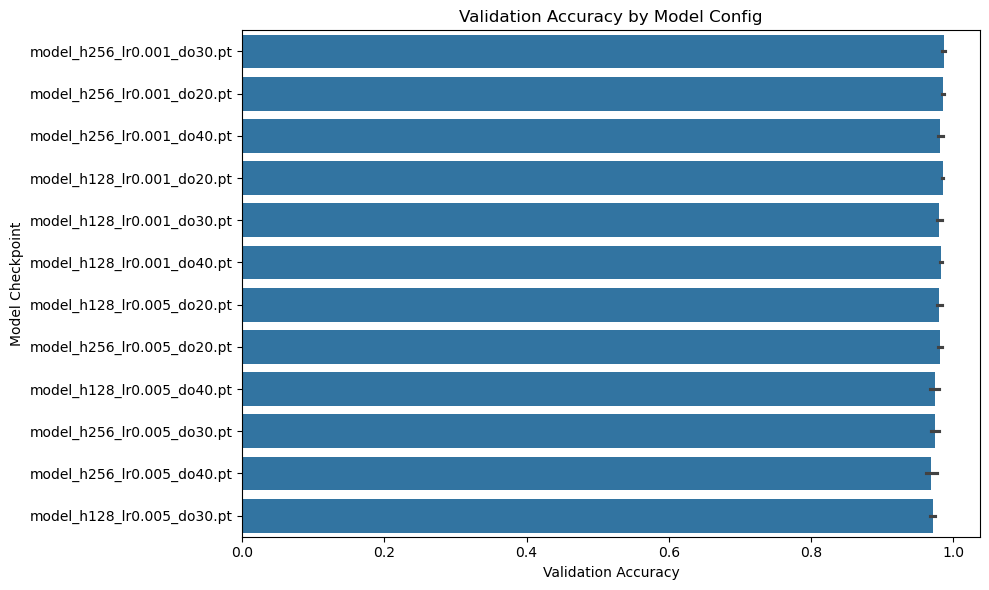

In [50]:
# Visualize the result of the grid search
print("Grid Search Results:")
print(df_results.sort_values(by='val_accuracy', ascending=False))

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results.sort_values(by='val_accuracy', ascending=False), x='val_accuracy', y='checkpoint')
plt.title("Validation Accuracy by Model Config")
plt.xlabel("Validation Accuracy")
plt.ylabel("Model Checkpoint")
plt.tight_layout()
plt.show()

In [51]:
print("Best Model Parameters After Fine-Tuning:")
print(f"→ Hidden Size:     {best_model_params['hidden_size']}")
print(f"→ Learning Rate:   {best_model_params['learning_rate']}")
print(f"→ Dropout:         {best_model_params['dropout']}")
print(f"→ Batch Size:      {best_model_params['batch_size']}")
print(f"→ Validation Acc:  {best_model_params['val_accuracy']:.4f}")
print(f"→ Checkpoint File: {best_model_params['checkpoint']}")

Best Model Parameters After Fine-Tuning:
→ Hidden Size:     256
→ Learning Rate:   0.001
→ Dropout:         0.3
→ Batch Size:      64
→ Validation Acc:  0.9885
→ Checkpoint File: model_h256_lr0.001_do30.pt


In [52]:
# Extract the best model as the final model
input_size = X_processed.shape[2] # no. of subcarries = 114
hidden_size = int(best_model_params['hidden_size'])
best_model = CNNLSTM(input_size=input_size, hidden_size=hidden_size, num_classes=len(class_names))
for layer in best_model.cnn:
    if isinstance(layer, torch.nn.Dropout):
        layer.p = best_model_params['dropout']
best_model.load_state_dict(torch.load(best_model_params['checkpoint']))
best_model

CNNLSTM(
  (cnn): Sequential(
    (0): Conv1d(114, 128, kernel_size=(5,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
  )
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=7, bias=True)
)

              precision    recall  f1-score   support

    get_down       0.93      0.90      0.92        42
      get_up       0.95      0.95      0.95        39
       lying       0.98      0.99      0.98        94
   no_person       0.98      0.98      0.98        90
     sitting       0.96      0.99      0.97        69
    standing       0.97      0.97      0.97        79
     walking       0.99      0.99      0.99       372

    accuracy                           0.98       785
   macro avg       0.97      0.97      0.97       785
weighted avg       0.98      0.98      0.98       785



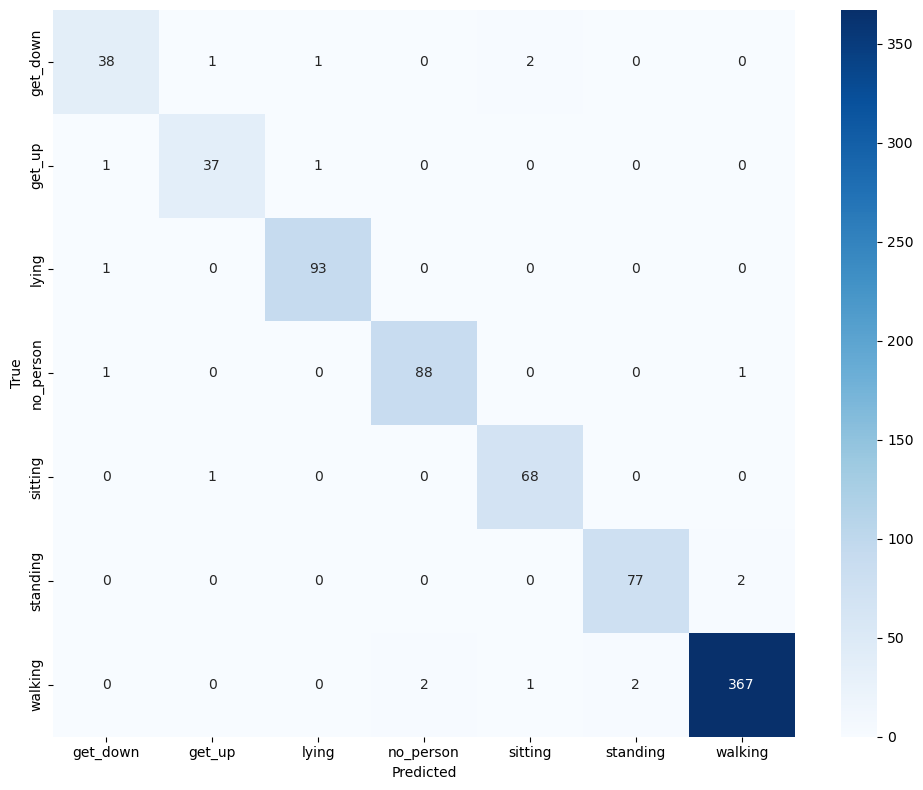

0.978343949044586

In [53]:
# Evaluate the final model
batch_size = int(best_model_params['batch_size'])
test_loader = DataLoader(CSIDataset(X_test, y_test), batch_size=batch_size)
evaluate_model(best_model, test_loader, device, True, class_names=class_names)

## 6. Conclusion and Suggestions for Improvement

This project successfully demonstrates the full pipeline for HAR using CSI data and deep learning. Some future potential improvements include:
- Try deeper CNN stacks (e.g., ResNet-style blocks) to capture more complex patterns.
- Experiment with attention mechanisms after LSTM layers to focus on important time steps.
- Augment the data with slight temporal shifts or subcarrier noise to improve robustness.
- Explore contrastive learning or self-supervised pretraining on raw CSI data before classification.
- Optimize hyperparameters (hidden size, kernel size, dropout rate) using random search or Optuna.

Even small changes in architecture or preprocessing can lead to significant improvements on HAR tasks.
